# Transfer learning

The tutorial demonstrates the basic application of transfer learning with TensorFlow Hub and Keras.

This notebook uses tf.keras, a high-level API to build and train models in TensorFlow, and tensorflow_hub, a library for loading trained models from TFHub in a single line of code. For a more advanced text classification tutorial using tf.keras, see the MLCC Text Classification Guide.

In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [2]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

2021-09-10 09:54:36.049031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47220 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:67:00.0, compute capability: 7.5
2021-09-10 09:54:36.050538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46873 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:68:00.0, compute capability: 7.5


# Explore the data

In [3]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

2021-09-10 09:54:36.665976: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [4]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

# Build the model 

In [5]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable= True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423194 , -0.01190171,  0.06337537,  0.0686297 , -0.16776839,
        -0.10581177,  0.168653  , -0.04998823, -0.31148052,  0.07910344,
         0.15442258,  0.01488661,  0.03930155,  0.19772716, -0.12215477,
        -0.04120982, -0.27041087, -0.21922147,  0.26517656, -0.80739075,
         0.25833526, -0.31004202,  0.2868321 ,  0.19433866, -0.29036498,
         0.0386285 , -0.78444123, -0.04793238,  0.41102988, -0.36388886,
        -0.58034706,  0.30269453,  0.36308962, -0.15227163, -0.4439151 ,
         0.19462997,  0.19528405,  0.05666233,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201319 , -0.04418665, -0.08550781,
        -0.55847436, -0.2333639 , -0.20782956, -0.03543065, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862677,  0.7753425 , -0.07667087,
        -0.15752274,  0.01872334, -0.08169781, -0.3521876 ,  0.46373403,
        -0.08492758,  0.07166861, -0.00670818,  0.12686071, -0.19326551,
 

In [6]:
model = tf.keras.Sequential([hub_layer, 
                            tf.keras.layers.Dense(16,activation='relu')
                            ,tf.keras.layers.Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 3s 71ms/step - loss: 0.6565 - accuracy: 0.5287 - val_loss: 0.6182 - val_accuracy: 0.5759
Epoch 2/10
30/30 [==============================] - 2s 57ms/step - loss: 0.5620 - accuracy: 0.6649 - val_loss: 0.5195 - val_accuracy: 0.7374
Epoch 3/10
30/30 [==============================] - 2s 57ms/step - loss: 0.4329 - accuracy: 0.8015 - val_loss: 0.4134 - val_accuracy: 0.8064
Epoch 4/10
30/30 [==============================] - 2s 58ms/step - loss: 0.3126 - accuracy: 0.8761 - val_loss: 0.3523 - val_accuracy: 0.8458
Epoch 5/10
30/30 [==============================] - 2s 56ms/step - loss: 0.2323 - accuracy: 0.9144 - val_loss: 0.3223 - val_accuracy: 0.8579
Epoch 6/10
30/30 [==============================] - 2s 59ms/step - loss: 0.1740 - accuracy: 0.9431 - val_loss: 0.3095 - val_accuracy: 0.8662
Epoch 7/10
30/30 [==============================] - 2s 59ms/step - loss: 0.1316 - accuracy: 0.9611 - val_loss: 0.3054 - val_accuracy: 0.8691
Epoch 8/10
30

# Evaluate the model

In [9]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 1s - loss: 0.3524 - accuracy: 0.8530 - 1s/epoch - 29ms/step
loss: 0.352
accuracy: 0.853


In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

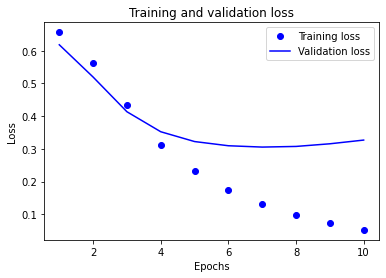

In [11]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


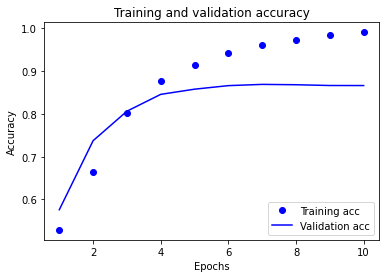

In [12]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()